In [30]:
import gurobipy as gb 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

In [2]:
brick_distances = pd.read_csv("./data/brick_rp_distances.csv")
brick_indices = pd.read_csv("./data/bricks_index_values.csv")


In [3]:
brick_distances.head()

,brick,rp1,rp2,rp3,rp4
0,1,16.16,24.09,24.29,21.12
1,2,19.00,26.47,27.22,17.33
2,3,25.29,32.50,33.41,12.25
3,4,0.00,7.94,8.29,36.12
4,5,3.07,6.45,7.55,37.37


In [4]:
brick_indices.head()

,brick,index_value
0,1,0.1609
1,2,0.1164
2,3,0.1026
3,4,0.1516
4,5,0.0939


In [5]:
current_assignment = np.zeros((22, 4))
current_assignment[[0, 1, 2, 3, 4], 0] = 1
current_assignment[[5, 6, 7, 8], 1] = 1
current_assignment[[9, 10, 11, 12, 13], 2] = 1
current_assignment[[14, 15, 16, 17, 18, 19, 20, 21], 3] = 1

### First model : Distance problem

In [6]:
distances = np.zeros((4,22))
for i in range(1,5):
    for j in range(22):
        distances[i-1,j] = brick_distances["rp"+str(i)].iloc[j]
workloads = np.array([brick_indices["index_value"].iloc[i] for i in range(22)])

In [7]:
dist_model = gb.Model("Distance")


variables = dist_model.addVars(4,22, vtype=gb.GRB.BINARY)


# Essential 
dist_model.addConstr(gb.quicksum([variables[i,j] for i in range(4) for j in range(22)]) == 22)
# One brick per SR
dist_model.addConstrs((gb.quicksum([variables[i,j] for i in range(4)]) == 1 for j in range(22)))

## Workload constraints
dist_model.addConstrs((gb.quicksum([workloads[j]* variables[i,j] for j in range(22)]) <= 1.2) 
                      for i in range(4) )
dist_model.addConstrs((gb.quicksum([workloads[j]* variables[i,j] for j in range(22)]) >= 0.8) 
                      for i in range(4) )

dist_model.setObjective(gb.quicksum([distances[i,j]*variables[i,j] for i in range(4) for j in range(22)]), GRB.MINIMIZE )

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2601656
Academic license 2601656 - for non-commercial use only - registered to ab___@student-cs.fr


NameError: name 'GRB' is not defined

In [27]:
import json
dist_model.params.outputflag = 0
dist_model.optimize()
opt_sol_print_str = json.dumps({str((i,j)): variables[i,j].x for i in range(4) for j in range(22)}, indent=4)
print(f"Got distance = {dist_model.objVal} \n Optimal solution = {opt_sol_print_str}")

Got distance = 154.62 
 Optimal solution = {
    "(0, 0)": -0.0,
    "(0, 1)": -0.0,
    "(0, 2)": -0.0,
    "(0, 3)": 1.0,
    "(0, 4)": 1.0,
    "(0, 5)": 1.0,
    "(0, 6)": 1.0,
    "(0, 7)": 1.0,
    "(0, 8)": 1.0,
    "(0, 9)": -0.0,
    "(0, 10)": -0.0,
    "(0, 11)": 1.0,
    "(0, 12)": -0.0,
    "(0, 13)": -0.0,
    "(0, 14)": -0.0,
    "(0, 15)": -0.0,
    "(0, 16)": -0.0,
    "(0, 17)": -0.0,
    "(0, 18)": 1.0,
    "(0, 19)": 1.0,
    "(0, 20)": -0.0,
    "(0, 21)": -0.0,
    "(1, 0)": -0.0,
    "(1, 1)": -0.0,
    "(1, 2)": -0.0,
    "(1, 3)": -0.0,
    "(1, 4)": -0.0,
    "(1, 5)": -0.0,
    "(1, 6)": -0.0,
    "(1, 7)": -0.0,
    "(1, 8)": -0.0,
    "(1, 9)": -0.0,
    "(1, 10)": 1.0,
    "(1, 11)": -0.0,
    "(1, 12)": 1.0,
    "(1, 13)": 1.0,
    "(1, 14)": -0.0,
    "(1, 15)": -0.0,
    "(1, 16)": 0.0,
    "(1, 17)": 1.0,
    "(1, 18)": -0.0,
    "(1, 19)": -0.0,
    "(1, 20)": -0.0,
    "(1, 21)": -0.0,
    "(2, 0)": -0.0,
    "(2, 1)": -0.0,
    "(2, 2)": -0.0,
    "

## Second model: disruption

In [12]:
disrupt_model = gb.Model("Distruption model")

variables = disrupt_model.addVars(4,22, vtype=gb.GRB.BINARY)
# Constraints :
## Essential 
disrupt_model.addConstr(gb.quicksum([variables[i,j] for i in range(4) for j in range(22)]) == 22)
## One brick per SR
disrupt_model.addConstrs((gb.quicksum([variables[i,j] for i in range(4)]) == 1 for j in range(22)))

## Workload constraints
disrupt_model.addConstrs((gb.quicksum([workloads[j]* variables[i,j] for j in range(22)]) <= 1.2) 
                      for i in range(4) )
disrupt_model.addConstrs((gb.quicksum([workloads[j]* variables[i,j] for j in range(22)]) >= 0.8) 
                      for i in range(4) )

## Aux var definitions:

disrupt_model.setObjective(gb.quicksum([(variables[i,j] - current_assignment[j,i])**2 * workloads[j]
                                    for i in range(4) for j in range(22)] )
, gb.GRB.MINIMIZE )

In [13]:
disrupt_model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2601656 - for non-commercial use only - registered to ab___@student-cs.fr
Optimize a model with 31 rows, 88 columns and 352 nonzeros
Model fingerprint: 0xb299948f
Model has 88 quadratic objective terms
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [9e-02, 2e+00]
  QObjective range [9e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 2e+01]
Found heuristic solution: objective 7.5090000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 9.386000e-01, 14 iterations, 0.00 seconds (0.00 work units

In [14]:
disrupt_model.objVal

1.0202

# Epsilon-Constraint model

In [20]:
def obj_1(var):
    return sum([distances[i,j]*var[i,j] for i in range(4) for j in range(22)])

def obj_2(var):
    return sum([(var[i,j] - current_assignment[j,i])**2 * workloads[j]
                                        for i in range(4) for j in range(22)] )

In [41]:
def get_solution(epsilon=10000000,workload_min=0.8, workload_max=1.2):
    constraint_model = gb.Model(f"Distruption model w/ epsilon={epsilon}")

    variables = constraint_model.addVars(4,22, vtype=gb.GRB.BINARY)
    # Constraints :
    ## Essential 
    constraint_model.addConstr(gb.quicksum([variables[i,j] for i in range(4) for j in range(22)]) == 22)
    ## One brick per SR
    constraint_model.addConstrs((gb.quicksum([variables[i,j] for i in range(4)]) == 1 for j in range(22)))

    ## Workload constraints
    constraint_model.addConstrs((gb.quicksum([workloads[j]* variables[i,j] for j in range(22)]) <= workload_max) 
                        for i in range(4) )
    constraint_model.addConstrs((gb.quicksum([workloads[j]* variables[i,j] for j in range(22)]) >= workload_min) 
                        for i in range(4) )

    ## Epsilon constraint
    constraint_model.addConstr(obj_2(variables) <= epsilon)

    constraint_model.setObjective(obj_1(variables), gb.GRB.MINIMIZE )

    constraint_model.params.outputflag = 0

    constraint_model.optimize()

    return constraint_model, variables, obj_1(variables), obj_2(variables)

Couldn't calculate objective function.
Couldn't calculate objective function.
Couldn't calculate objective function.


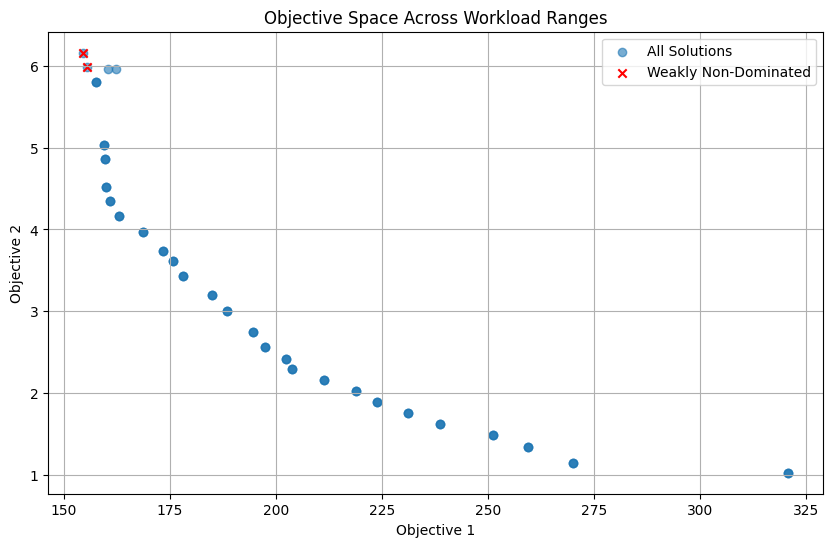

In [42]:


def get_nd_sols(workload_min=0.8, workload_max=1.2):
    step = 0.1
    epsilon = None
    res, init_solution, obj1, obj2 = get_solution(workload_min=workload_min, workload_max=workload_max)
    solutions = [init_solution]
    sol_vals = [(obj1.getValue(), obj2.getValue())]
    
    while hasattr(res, "objVal"):
        # Cleaned up the value extraction
        values = np.array([[solutions[-1][i, j].x for j in range(22)] for i in range(4)])
        epsilon = obj_2(values) - step
        res, solution, obj1, obj2 = get_solution(epsilon)
        try:
            sol_vals.append((obj1.getValue(), obj2.getValue()))
        except:
            print("Couldn't calculate objective function.")
        solutions.append(solution)
    return sol_vals

# Function to find weakly non-dominated solutions
def find_weakly_non_dominated(solutions):
    non_dominated = []
    for i, sol in enumerate(solutions):
        dominated = False
        for j, other_sol in enumerate(solutions):
            if j != i and other_sol[0] <= sol[0] and other_sol[1] <= sol[1]:
                dominated = True
                break
        if not dominated:
            non_dominated.append(sol)
    return non_dominated

# Workload ranges
workload_ranges = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]

# Collect solutions for all workload ranges
all_solutions = []
for workload_min, workload_max in workload_ranges:
    sol_vals = get_nd_sols(workload_min, workload_max)
    all_solutions.extend(sol_vals)

# Extract weakly non-dominated solutions from combined results
weakly_non_dominated = find_weakly_non_dominated(all_solutions)

# Plotting
all_obj1, all_obj2 = zip(*all_solutions)
non_dom_obj1, non_dom_obj2 = zip(*weakly_non_dominated)

plt.figure(figsize=(10, 6))
plt.scatter(all_obj1, all_obj2, label="All Solutions", alpha=0.6)
plt.scatter(non_dom_obj1, non_dom_obj2, color="red", label="Weakly Non-Dominated", marker="x")
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.title("Objective Space Across Workload Ranges")
plt.legend()
plt.grid()
plt.show()


In [40]:
def get_nd_sols(workload_min = 0.8, workload_max=1.2):
    step = 0.1
    epsilon = None
    res, init_solution, obj1, obj2 = get_solution()
    solutions = [init_solution]
    sol_vals = [(obj1.getValue(), obj2.getValue())]
    while hasattr(res, "objVal"):
        # TODO: ugly quick thing, to clean up
        values = np.zeros((4,22))
        for i in range(4):
            for j in range(22): 
                values[i,j] = solutions[-1][i,j].x
        epsilon = obj_2(values) - step
        res, solution, obj1, obj2 = get_solution(epsilon)
        try:
            sol_vals.append((obj1.getValue(), obj2.getValue()))
        except:
            print("couldn't calculate obj function")
        solutions.append(solution)
    return sol_vals

In [36]:
# Function to find weakly non-dominated solutions
def find_weakly_non_dominated(solutions):
    non_dominated = []
    for i, sol in enumerate(solutions):
        dominated = False
        for j, other_sol in enumerate(solutions):
            if j != i and other_sol[0] <= sol[0] and other_sol[1] <= sol[1]:
                dominated = True
                break
        if not dominated:
            non_dominated.append(sol)
    return non_dominated

# Extract weakly non-dominated solutions
sol_vals = []
weakly_non_dominated = []
for (a,b) in [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]:
    sol_vals.append(get_nd_sols())
    weakly_non_dominated.append(find_weakly_non_dominated(sol_vals[-1]))

# Plot all solutions and highlight non-dominated ones
all_obj1, all_obj2 = zip(*sol_vals)
non_dom_obj1, non_dom_obj2 = zip(*sum(weakly_non_dominated))

plt.figure(figsize=(8, 6))
plt.scatter(all_obj1, all_obj2, label="All Solutions", alpha=0.6)
plt.scatter(non_dom_obj1, non_dom_obj2, color="red", label="Weakly Non-Dominated", marker="x")
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.title("Objective Space")
plt.legend()
plt.grid()
plt.show()

couldn't calculate obj function
couldn't calculate obj function
couldn't calculate obj function


ValueError: not enough values to unpack (expected 2, got 0)

[]